# Importing The Packages & Reading The Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from skimage import data
from skimage import color
from skimage.filters import gaussian, sobel
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from copy import copy
from skimage.feature import canny 
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_nl_means, denoise_tv_bregman, denoise_wavelet
from skimage import measure
from skimage import exposure
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, Reshape, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import os
%matplotlib inline

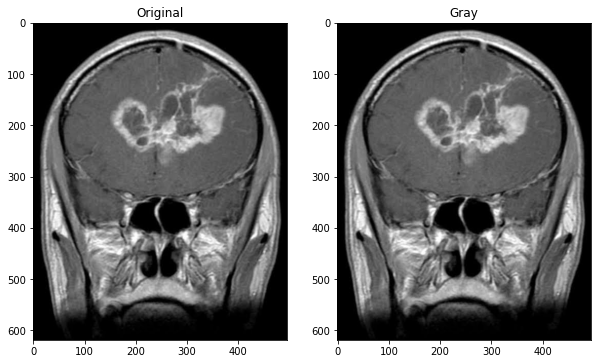

In [ ]:
img  = plt.imread('/content/drive/MyDrive/Datasets/Brain_Tumor_Images/Testing/glioma_tumor/image(1).jpg')

plt.figure(figsize=(10,13))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(img);

plt.subplot(1,2,2)
plt.imshow(color.rgb2gray(img), cmap='gray')
plt.title('Gray');

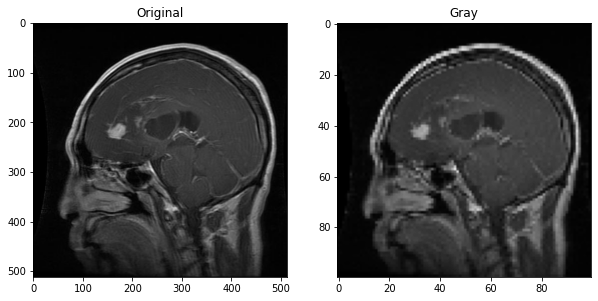

In [ ]:
img  = plt.imread('/content/drive/MyDrive/Datasets/Brain_Tumor_Images/Training/glioma_tumor/gg (192).jpg')

plt.figure(figsize=(10,13))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(img);

img_2 = cv.resize(color.rgb2gray(img), (100, 100))

plt.subplot(1,2,2)
plt.imshow(img_2, cmap='gray')
plt.title('Gray');

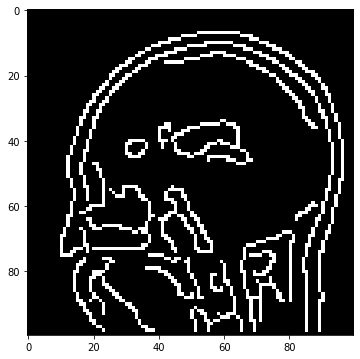

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(canny(img_2, sigma=1.5), cmap='gray');

### Functions

In [ ]:
def LoadPaths(path):
    '''Put files into lists and return them as one list with all images 
     in the folder'''
     
    image_files = sorted([os.path.join(path, file)
                          for file in os.listdir(path)
                          if file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png')])
    
    return image_files

In [ ]:
def LoadImages(path_list):
    for i in range(len(path_list)):
    path_list[i] = cv.resize(cv.imread(path_list[i], 0), (100, 100))

      return np.array(path_list)

### Loading The Train Data

In [ ]:
train_glioma = LoadImages(LoadPaths('/content/drive/MyDrive/Datasets/Brain_Tumor_Images/Training/glioma_tumor'))

In [ ]:
train_meningioma = LoadImages(LoadPaths('/content/drive/MyDrive/Datasets/Brain_Tumor_Images/Training/meningioma_tumor'))

In [ ]:
train_pituitary = LoadImages(LoadPaths('/content/drive/MyDrive/Datasets/Brain_Tumor_Images/Training/pituitary_tumor'))

In [ ]:
train_notumor = LoadImages(LoadPaths('/content/drive/MyDrive/Datasets/Brain_Tumor_Images/Training/no_tumor'))

In [ ]:
train_glioma.shape

(826, 100, 100)

In [ ]:
train_meningioma.shape

(822, 100, 100)

In [ ]:
train_pituitary.shape

(827, 100, 100)

In [ ]:
train_notumor.shape

(395, 100, 100)

### Loading The Test Data 

In [ ]:
test_glioma = LoadImages(LoadPaths('/content/drive/MyDrive/Datasets/Brain_Tumor_Images/Testing/glioma_tumor'))

In [ ]:
test_meningioma = LoadImages(LoadPaths('/content/drive/MyDrive/Datasets/Brain_Tumor_Images/Testing/meningioma_tumor'))

In [ ]:
test_pituitary = LoadImages(LoadPaths('/content/drive/MyDrive/Datasets/Brain_Tumor_Images/Testing/pituitary_tumor'))

In [ ]:
test_notumor = LoadImages(LoadPaths('/content/drive/MyDrive/Datasets/Brain_Tumor_Images/Testing/no_tumor'))

In [ ]:
test_glioma.shape

(100, 100, 100)

In [ ]:
test_meningioma.shape

(115, 100, 100)

In [ ]:
test_pituitary.shape

(74, 100, 100)

In [ ]:
test_notumor.shape

(105, 100, 100)

# Preprocessing The Data

### Train Data

In [ ]:
total_train_images = train_glioma.shape[0] + train_meningioma.shape[0] + train_notumor.shape[0] + train_pituitary.shape[0]
total_train_images

2870

In [ ]:
x_train = np.concatenate((train_glioma, train_meningioma, train_pituitary, train_notumor), axis=0)
x_train.shape

(2870, 100, 100)

In [ ]:
for i in range(x_train.shape[0]):
    x_train[i] = canny(x_train[i], sigma=1.5)

In [ ]:
y_train = np.zeros(train_glioma.shape[0])
y_train = np.concatenate((y_train, np.full(train_meningioma.shape[0], 1)), axis=None)
y_train = np.concatenate((y_train, np.full(train_pituitary.shape[0], 2)), axis=None)
y_train = np.concatenate((y_train, np.full(train_notumor.shape[0], 3)), axis=None)
y_train.shape

(2870,)

In [ ]:
y_train = to_categorical(y_train, 4)
y_train.shape

(2870, 4)

In [ ]:
X_Train, Y_Train = shuffle(x_train, y_train)

In [ ]:
X_Train.shape

(2870, 100, 100)

In [ ]:
Y_Train.shape

(2870, 4)

### Test Data

In [ ]:
total_test_images = test_glioma.shape[0] + test_meningioma.shape[0] + test_notumor.shape[0] + test_pituitary.shape[0]
total_test_images

394

In [ ]:
x_test = np.concatenate((test_glioma, test_meningioma, test_pituitary, test_notumor), axis=0)
x_test.shape

(394, 100, 100)

In [ ]:
for i in range(x_test.shape[0]):
    x_test[i] = canny(x_test[i], sigma=1.5)

In [ ]:
y_test = np.zeros(test_glioma.shape[0])
y_test = np.concatenate((y_test, np.full(test_meningioma.shape[0], 1)), axis=None)
y_test = np.concatenate((y_test, np.full(test_pituitary.shape[0], 2)), axis=None)
y_test = np.concatenate((y_test, np.full(test_notumor.shape[0], 3)), axis=None)
y_test.shape

(394,)

In [ ]:
y_test = to_categorical(y_test, 4)
y_test.shape

(394, 4)

In [ ]:
X_Test, Y_Test = shuffle(x_test, y_test)

In [ ]:
X_Test.shape

(394, 100, 100)

In [ ]:
Y_Test.shape

(394, 4)

# MinMax & Reshaping The Images

In [ ]:
X_Train.max()

255

In [ ]:
X_Test.max()

255

In [ ]:
X_Train = X_Train.reshape(X_Train.shape[0], 100, 100, 1)
X_Test = X_Test.reshape(X_Test.shape[0], 100, 100, 1)

In [ ]:
X_Train.shape

(2870, 100, 100, 1)

In [ ]:
X_Test.shape

(394, 100, 100, 1)

# Building The Model

In [ ]:
datagen_2 = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    zoom_range = 0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=True,
    vertical_flip=False)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16928)            

In [ ]:
datagen_2.fit(X_Train)
model.fit_generator(datagen_2.flow(X_Train,Y_Train), epochs = 30, validation_data = (X_Test,Y_Test))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
90/90 [==============================] - 73s 811ms/step - loss: 0.6077 - accuracy: 0.7415 - val_loss: 2.4087 - val_accuracy: 0.5330
Epoch 2/30
90/90 [==============================] - 72s 805ms/step - loss: 0.4811 - accuracy: 0.7993 - val_loss: 2.2814 - val_accuracy: 0.6091
Epoch 3/30
90/90 [==============================] - 72s 804ms/step - loss: 0.3737 - accuracy: 0.8537 - val_loss: 1.9145 - val_accuracy: 0.6751
Epoch 4/30
90/90 [==============================] - 72s 801ms/step - loss: 0.2800 - accuracy: 0.8892 - val_loss: 2.4268 - val_accuracy: 0.7157
Epoch 5/30
90/90 [==============================] - 72s 801ms/step - loss: 0.2157 - accuracy: 0.9216 - val_loss: 2.6351 - val_accuracy: 0.7208
Epoch 6/30
90/90 [==============================] - 74s 827ms/step - loss: 0.1412 - accuracy: 0.9474 - val_loss: 2.7573 - val_accuracy: 0.7411
Epoch 7/30
90/90 [==============================] - 76s 848ms/step - loss: 0.1023 - accuracy: 0.9676 - val_loss: 3.3699 - val_accuracy: 0.7614

# Model Evaluation


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
loss = pd.DataFrame(model.history.history)

In [ ]:
loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.607679,0.741463,2.408662,0.532995
1,0.481062,0.799303,2.281350,0.609137
2,0.373686,0.853659,1.914548,0.675127
3,0.279993,0.889199,2.426790,0.715736
4,0.215740,0.921603,2.635086,0.720812


Text(0.5, 1.0, 'Accuracy Curves')

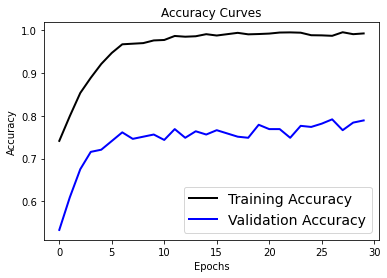

In [ ]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(model.history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(model.history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

In [ ]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(model_4.history.history['loss'], 'black', linewidth=2.0)
plt.plot(model_4.history.history['val_loss'], 'red', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [ ]:
y_pred = np.argmax(model.predict(X_Test), axis=-1)

In [ ]:
y_pred

array([9, 2, 1, ..., 8, 1, 5])

In [ ]:
y_test_classes = np.argmax(Y_Test, axis=-1)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test_classes, y_pred), annot=True, cbar=True, cmap="YlGnBu");
plt.yticks(rotation=360);
plt.title('Confusion Matrix');